In [2]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

# Timing Processes and Progress
import time
from tqdm import tqdm
import itertools

# make sure the figures plot inline rather than at the end
%matplotlib inline

In [3]:
def add_land(ax,bounds= [45,100,0,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

# month of min doxy  --------------------------------------------------------------------#
def latlonbin_min_doxy(doxy,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy = np.array(doxy),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(doxy.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    min_doxy = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_mon = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_seas = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpdoxy = np.array(group.doxy)

        # find month of minimum OCD
        if ~np.isnan(np.nanmin(gpdoxy)):
            
            min_doxy[i[0],j[0]] = np.nanmin(gpdoxy)
            
            ind = np.nanargmin(gpdoxy)
            min_month = gpmonth[ind]
            if len(gpdoxy[gpdoxy == np.nanmin(gpdoxy)])>1:
                print('Duplicate Values in Minimum.', len(gpdoxy[gpdoxy == np.nanmin(gpdoxy)]),
                      gpmonth[gpdoxy == np.nanmin(gpdoxy)] )
            
            min_doxy_mon[i[0],j[0]] = min_month
            
            if (min_month == 3) | (min_month == 4) | (min_month == 5):
                min_doxy_seas[i[0],j[0]] = 0
            elif (min_month == 6) | (min_month == 7) | (min_month == 8):
                min_doxy_seas[i[0],j[0]] = 1
            elif (min_month == 9) | (min_month == 10) | (min_month == 11):
                min_doxy_seas[i[0],j[0]] = 2
            elif (min_month == 12) | (min_month == 1) | (min_month == 2):
                min_doxy_seas[i[0],j[0]] = 3
  

    return(np.array(min_doxy,dtype = float),np.array(min_doxy_mon,dtype = float),
           np.array(min_doxy_seas,dtype = float),
           latbins,lonbins)

# month of max doxy -----------------------------------------------------------------#
def latlonbin_max_doxy(doxy,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy = np.array(doxy),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(doxy.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    max_doxy = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    max_doxy_mon = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    max_doxy_seas = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpdoxy = np.array(group.doxy)

        # find month of minimum OCD
        if ~np.isnan(np.nanmax(gpdoxy)):
            
            max_doxy[i[0],j[0]] = np.nanmax(gpdoxy)
            
            ind = np.nanargmin(gpdoxy)
            max_month = gpmonth[ind]
            if len(gpdoxy[gpdoxy == np.nanmax(gpdoxy)])>1:
                print('Duplicate Values in Maximum.', len(gpdoxy[gpdoxy == np.nanmax(gpdoxy)]),
                      gpmonth[gpdoxy == np.nanmax(gpdoxy)] )
            
            max_doxy_mon[i[0],j[0]] = max_month
            
            if (max_month == 3) | (max_month == 4) | (max_month == 5):
                max_doxy_seas[i[0],j[0]] = 0
            elif (max_month == 6) | (max_month == 7) | (max_month == 8):
                max_doxy_seas[i[0],j[0]] = 1
            elif (max_month == 9) | (max_month == 10) | (max_month == 11):
                max_doxy_seas[i[0],j[0]] = 2
            elif (max_month == 12) | (max_month == 1) | (max_month == 2):
                max_doxy_seas[i[0],j[0]] = 3
  

    return(np.array(max_doxy,dtype = float),np.array(max_doxy_mon,dtype = float),
           np.array(max_doxy_seas,dtype = float),
           latbins,lonbins)



def IOD_year_group(invar,inlat,inlon,intime,begin,end,IODyears):
    data= []
    lat = []
    lon = []
    time = []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
#         print(time_slice)
        data.extend(np.array(invar.sel(time=time_slice)))
        lat.extend(np.array(inlat.sel(time=time_slice)))
        lon.extend(np.array(inlon.sel(time=time_slice)))
        time.extend(np.array(intime.sel(time=time_slice)))
        
    return data,lat,lon,time

def IOD_year_group_coast(invar,inlat,inlon,intime,begin,end,IODyears):
    data= []
    lat = []
    lon = []
    time = []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
#         print(time_slice)
        data.extend(np.array(invar.sel(coast_time=time_slice)))
        lat.extend(np.array(inlat.sel(coast_time=time_slice)))
        lon.extend(np.array(inlon.sel(coast_time=time_slice)))
        time.extend(np.array(intime.sel(coast_time=time_slice)))
        
    return np.array(data),np.array(lat),np.array(lon),np.array(time)

In [4]:
# CP
path_CD = '../data/CD/'
infn_CD = 'awg_cd.nc'

ds_CD= xr.open_dataset(path_CD + infn_CD)
ds_CD


<xarray.Dataset>
Dimensions:                      (coast_time: 52855, latbins: 50, lonbins: 85, month: 306118, pres: 201, time: 306118, upper_pres: 99)
Coordinates:
    prof                         (time) int32 ...
  * time                         (time) datetime64[ns] 1827-10-30 ... 2020-02-07
  * pres                         (pres) int32 0 5 10 15 20 ... 985 990 995 1000
  * month                        (month) int64 10 5 12 2 5 2 2 ... 2 2 2 2 2 2 2
  * upper_pres                   (upper_pres) int32 10 15 20 25 ... 490 495 500
  * latbins                      (latbins) float64 -20.0 -19.0 ... 28.0 29.0
  * lonbins                      (lonbins) float64 35.0 36.0 ... 118.0 119.0
  * coast_time                   (coast_time) datetime64[ns] 1858-03-01 ... 2020-02-07
Data variables:
    lon                          (time) float32 ...
    lat                          (time) float32 ...
    temp_AWG                     (time, pres) float32 ...
    doxy_AWG                     (time, pres

In [5]:
mask = mask_coast(np.array(ds_CD.lon),np.array(ds_CD.lat),[35,120,-20,30])
mask.shape

(306118,)

In [6]:
# total

var = ds_CD.doxy_50_200_ave

binwidth = 2
bounds = [35,120,-20,30]

#######################################################




In [7]:
# AS

ASind = (ds_CD.lat_coast > 8) & (ds_CD.lat_coast <23) & (ds_CD.lon_coast < 78) & (ds_CD.lon_coast >68)

temp_AS_10_200 = ds_CD.temp_10_200_ave_coast[ASind]
doxy_AS_10_200 = ds_CD.doxy_10_200_ave_coast[ASind]

temp_AS_10_50 = ds_CD.temp_10_50_ave_coast[ASind]
doxy_AS_10_50 = ds_CD.doxy_10_50_ave_coast[ASind]

temp_AS_50_200 = ds_CD.temp_50_200_ave_coast[ASind]
doxy_AS_50_200 = ds_CD.doxy_50_200_ave_coast[ASind]

lat_AS = ds_CD.lat_coast[ASind]
lon_AS = ds_CD.lon_coast[ASind]
time_AS = ds_CD.coast_time[ASind]
seas_AS = time_AS.dt.season

In [8]:
# WBoB

wBoBind = (ds_CD.lat_coast > 9) & (ds_CD.lat_coast <23) & (ds_CD.lon_coast < 90) & (ds_CD.lon_coast >78)

temp_wBoB_10_200 = ds_CD.temp_10_200_ave_coast[wBoBind]
doxy_wBoB_10_200 = ds_CD.doxy_10_200_ave_coast[wBoBind]

temp_wBoB_10_50 = ds_CD.temp_10_50_ave_coast[wBoBind]
doxy_wBoB_10_50 = ds_CD.doxy_10_50_ave_coast[wBoBind]

temp_wBoB_50_200 = ds_CD.temp_50_200_ave_coast[wBoBind]
doxy_wBoB_50_200 = ds_CD.doxy_50_200_ave_coast[wBoBind]

lat_wBoB = ds_CD.lat_coast[wBoBind]
lon_wBoB = ds_CD.lon_coast[wBoBind]
time_wBoB = ds_CD.coast_time[wBoBind]
seas_wBoB = time_wBoB.dt.season

In [9]:
# EBoB

eBoBind = (ds_CD.lat_coast > 2) & (ds_CD.lat_coast <21) & (ds_CD.lon_coast < 101) & (ds_CD.lon_coast >90)

temp_eBoB_10_200 = ds_CD.temp_10_200_ave_coast[eBoBind]
doxy_eBoB_10_200 = ds_CD.doxy_10_200_ave_coast[eBoBind]

temp_eBoB_10_50 = ds_CD.temp_10_50_ave_coast[eBoBind]
doxy_eBoB_10_50 = ds_CD.doxy_10_50_ave_coast[eBoBind]

temp_eBoB_50_200 = ds_CD.temp_50_200_ave_coast[eBoBind]
doxy_eBoB_50_200 = ds_CD.doxy_50_200_ave_coast[eBoBind]

lat_eBoB = ds_CD.lat_coast[eBoBind]
lon_eBoB = ds_CD.lon_coast[eBoBind]
time_eBoB = ds_CD.coast_time[eBoBind]

ind = (lat_eBoB > 2) & (lat_eBoB <16) & (lon_eBoB < 86) & (lon_eBoB >77)

# doxy_eBoB_10_200 = np.where(~ind,doxy_eBoB_10_200,np.nan)
# doxy_eBoB_10_50 = np.where(~ind,doxy_eBoB_10_50,np.nan)
# doxy_eBoB_50_200 = np.where(~ind,doxy_eBoB_50_200,np.nan)

# doxy_eBoB_10_200 = doxy_eBoB_10_200[~ind]
# doxy_eBoB_10_50 = doxy_eBoB_10_50[~ind]
# doxy_eBoB_50_200 = doxy_eBoB_50_200[~ind]

# lat_eBoB = lat_eBoB[~ind]
# lon_eBoB = lon_eBoB[~ind]

# time_eBoB = time_eBoB[~ind]
seas_eBoB = time_eBoB.dt.season
#finish rest

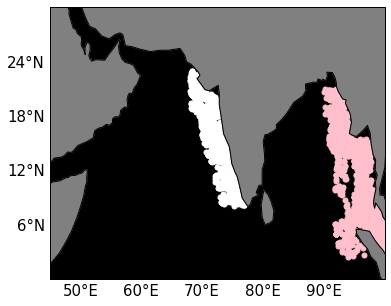

In [10]:
# make a scatter plot with rectangles to outline different locations...don't need in the figure necessairly.

    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax)
p =plt.scatter(lon_AS[~np.isnan(doxy_AS_10_50)],lat_AS[~np.isnan(doxy_AS_10_50)],
            s = 100,c='white',marker = '.')

# p =plt.scatter(lon_wBoB[~np.isnan(doxy_wBoB_10_50)],lat_wBoB[~np.isnan(doxy_wBoB_10_50)],
#             s = 100,c='yellow',marker = '.')


p =plt.scatter(lon_eBoB[~np.isnan(doxy_eBoB_10_50)],lat_eBoB[~np.isnan(doxy_eBoB_10_50)],
            s = 100,c='pink',marker = '.')

In [11]:
# group AS into IOD years

# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# groupd into IOD years

IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

In [12]:
# Arabian Sea

# 10-200

####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_AS_10_200,posIODlat_AS_10_200,posIODlon_AS_10_200,posIODtime_AS_10_200 = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_AS_10_200,negIODlat_AS_10_200,negIODlon_AS_10_200,negIODtime_AS_10_200 = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_AS_10_200,neuIODlat_AS_10_200,neuIODlon_AS_10_200,neuIODtime_AS_10_200 = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,neuIODyears)



# 10-50
####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_AS_10_50,posIODlat_AS_10_50,posIODlon_AS_10_50,posIODtime_AS_10_50 = IOD_year_group_coast(doxy_AS_10_50,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_AS_10_50,negIODlat_AS_10_50,negIODlon_AS_10_50,negIODtime_AS_10_50 = IOD_year_group_coast(doxy_AS_10_50,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_AS_10_50,neuIODlat_AS_10_50,neuIODlon_AS_10_50,neuIODtime_AS_10_50 = IOD_year_group_coast(doxy_AS_10_50,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,neuIODyears)

# 50-200
####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_AS_50_200,posIODlat_AS_50_200,posIODlon_AS_50_200,posIODtime_AS_50_200 = IOD_year_group_coast(doxy_AS_50_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_AS_50_200,negIODlat_AS_50_200,negIODlon_AS_50_200,negIODtime_AS_50_200 = IOD_year_group_coast(doxy_AS_50_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_AS_50_200,neuIODlat_AS_50_200,neuIODlon_AS_50_200,neuIODtime_AS_50_200 = IOD_year_group_coast(doxy_AS_50_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,neuIODyears)


In [13]:
# eBoB

# 10-200

####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_eBoB_10_200,posIODlat_eBoB_10_200,posIODlon_eBoB_10_200,posIODtime_eBoB_10_200 = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_eBoB_10_200,negIODlat_eBoB_10_200,negIODlon_eBoB_10_200,negIODtime_eBoB_10_200 = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_eBoB_10_200,neuIODlat_eBoB_10_200,neuIODlon_eBoB_10_200,neuIODtime_eBoB_10_200 = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,neuIODyears)



# 10-50
####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_eBoB_10_50,posIODlat_eBoB_10_50,posIODlon_eBoB_10_50,posIODtime_eBoB_10_50 = IOD_year_group_coast(doxy_eBoB_10_50,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_eBoB_10_50,negIODlat_eBoB_10_50,negIODlon_eBoB_10_50,negIODtime_eBoB_10_50 = IOD_year_group_coast(doxy_eBoB_10_50,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_eBoB_10_50,neuIODlat_eBoB_10_50,neuIODlon_eBoB_10_50,neuIODtime_eBoB_10_50 = IOD_year_group_coast(doxy_eBoB_10_50,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,neuIODyears)

# 50-200
####################################
# average over the positive IOD years -------------------------------------------# 
posIODdata_eBoB_50_200,posIODlat_eBoB_50_200,posIODlon_eBoB_50_200,posIODtime_eBoB_50_200 = IOD_year_group_coast(doxy_eBoB_50_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIODdata_eBoB_50_200,negIODlat_eBoB_50_200,negIODlon_eBoB_50_200,negIODtime_eBoB_50_200 = IOD_year_group_coast(doxy_eBoB_50_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,negIODyears)



# average over the positive IOD years -------------------------------------------# 
neuIODdata_eBoB_50_200,neuIODlat_eBoB_50_200,neuIODlon_eBoB_50_200,neuIODtime_eBoB_50_200 = IOD_year_group_coast(doxy_eBoB_50_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,neuIODyears)



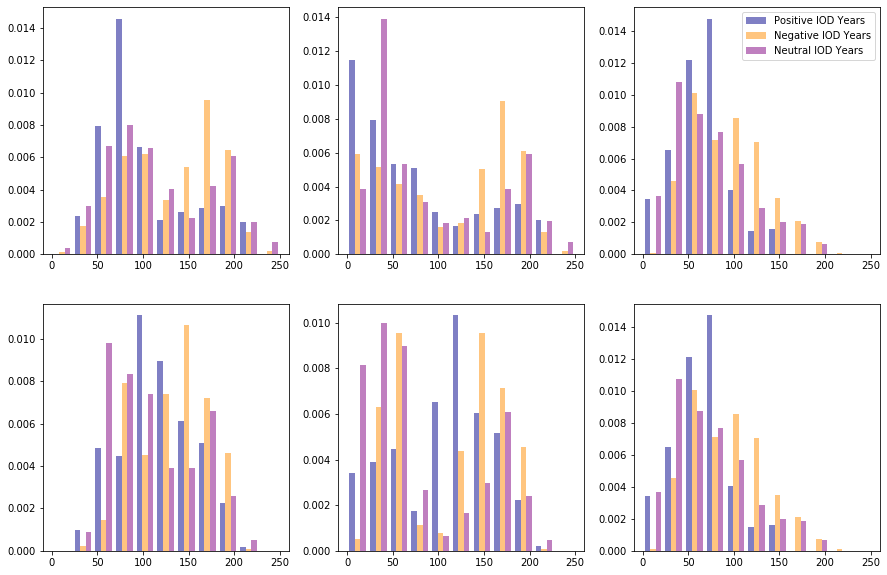

In [14]:
# Make Histograms 
binedges = np.linspace(0,250,12)
names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
colors = ['darkblue','darkorange','purple']

fig = plt.figure(figsize=(15, 10))

#########################

# group data

# data_AS_10_200 = [posIODdata_AS_10_200,negIODdata_AS_10_200,neuIODdata_AS_10_200]
# data_eBoB_10_200 = [posIODdata_eBoB_10_200,negIODdata_eBoB_10_200,neuIODdata_eBoB_10_200]

# data_AS_10_50 = [posIODdata_AS_10_50,negIODdata_AS_10_50,neuIODdata_AS_10_50]
# data_AS_10_50 = [posIODdata_eBoB_10_50,negIODdata_eBoB_10_50,neuIODdata_eBoB_10_50]

# data_AS_50_200 = [posIODdata_AS_50_200,negIODdata_AS_50_200,neuIODdata_AS_50_200]
# data_AS_50_200 =  [posIODdata_eBoB_50_200,negIODdata_eBoB_50_200,neuIODdata_eBoB_50_200]

data_AS = [posIODdata_AS_10_200,posIODdata_AS_10_50,posIODdata_AS_50_200,
                  negIODdata_AS_10_200,negIODdata_AS_10_50,negIODdata_AS_50_200,
                  neuIODdata_AS_10_200,neuIODdata_AS_10_50,neuIODdata_AS_50_200]
                                

data_eBoB = [posIODdata_eBoB_10_200,posIODdata_eBoB_10_50,posIODdata_eBoB_50_200,
             negIODdata_eBoB_10_200,negIODdata_eBoB_10_50,negIODdata_eBoB_50_200,
             neuIODdata_eBoB_10_200,neuIODdata_eBoB_10_50,neuIODdata_eBoB_50_200]

cnt = 1
for pp in range(2):
    for cc in range(3):

        if cnt < 3:
            pdata = data_AS[cc]
            ndata = data_AS[cc+3]
            nudata = data_AS[cc+6]
        else:
            pdata = data_eBoB[cc]
            ndata = data_eBoB[cc+3]
            nudata = data_eBoB[cc+6]

        x1 = pdata[~np.isnan(pdata)]
        x2 = ndata[~np.isnan(ndata)]
        x3 = nudata[~np.isnan(nudata)]

        ax = fig.add_subplot(2,3,cnt)
        n, bins, patches = plt.hist([x1,x2,x3],bins = binedges,
                     density = True,alpha = 0.5,
                     color = colors, label=names)
        if cnt == 3:
            plt.legend()
        cnt = cnt + 1
    
    
    

In [15]:
for cc in range(1,9,3):
    print(cc)

1
4
7


In [16]:
# we want to know when the values of low or higher oxygen occur....

# do th 8-12 split so that you can see it more clearly....

# maybe show a bar chart with the numbers of months for oxy vals less than seasonal mean?





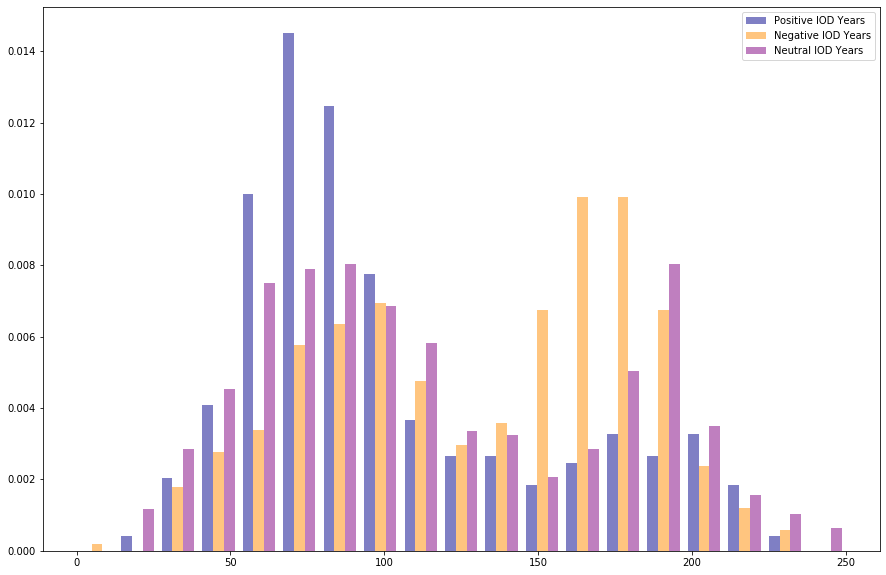

In [17]:
# group into IOD years

# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# groupd into IOD years

IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year


# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,posIODyears)
# ds_posIOD = xr.Dataset(coords={'time': posIODtime})
# ds_posIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD

# average over the positive IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,negIODyears)
# ds_negIOD = xr.Dataset(coords={'time': posIODtime})
# ds_negIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_negIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_negIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD



# average over the positive IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime = IOD_year_group_coast(doxy_AS_10_200,
                                             lat_AS,lon_AS,time_AS,
                                             IODyear_begin,IODyear_end,neuIODyears)
# ds_posIOD = xr.Dataset(coords={'time': posIODtime})
# ds_posIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD


binedges = np.linspace(0,250,20)
names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
x1 = posIODdata[~np.isnan(posIODdata)]
x2 = negIODdata[~np.isnan(negIODdata)]
x3 = neuIODdata[~np.isnan(neuIODdata)]

fig = plt.figure(figsize=(15, 10))
colors = ['darkblue','darkorange','purple']
n, bins, patches = plt.hist([x1,x2,x3],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
plt.legend()

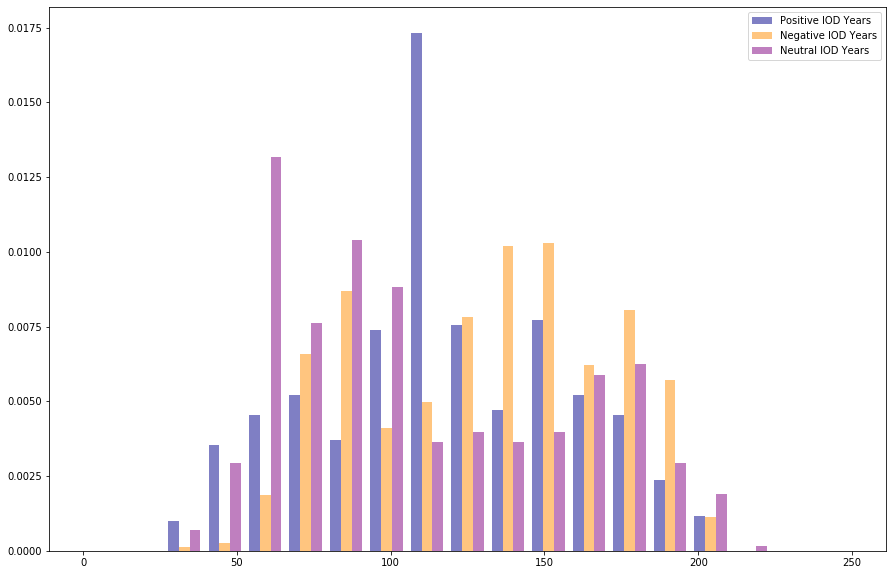

In [18]:
# group into IOD years

# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# groupd into IOD years

IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year


# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,posIODyears)
# ds_posIOD = xr.Dataset(coords={'time': posIODtime})
# ds_posIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD

# average over the positive IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,negIODyears)
# ds_negIOD = xr.Dataset(coords={'time': posIODtime})
# ds_negIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_negIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_negIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD



# average over the positive IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime = IOD_year_group_coast(doxy_eBoB_10_200,
                                             lat_eBoB,lon_eBoB,time_eBoB,
                                             IODyear_begin,IODyear_end,neuIODyears)
# ds_posIOD = xr.Dataset(coords={'time': posIODtime})
# ds_posIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
# ds_posIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])
# ds_posIOD


binedges = np.linspace(0,250,20)
names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
x1 = posIODdata[~np.isnan(posIODdata)]
x2 = negIODdata[~np.isnan(negIODdata)]
x3 = neuIODdata[~np.isnan(neuIODdata)]

fig = plt.figure(figsize=(15, 10))
colors = ['darkblue','darkorange','purple']
n, bins, patches = plt.hist([x1,x2,x3],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
plt.legend()

In [19]:
x2 = temp_AS_10_50[~np.isnan(temp_AS_10_50)]
x3 = temp_AS_10_50[~np.isnan(temp_AS_50_200)]

In [20]:
#end

In [21]:
var = ds_CD.doxy_10_200_ave

binwidth = 2
bounds = [35,120,-20,30]


#######################################################

# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

# groupd into IOD years

IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             IODyear_begin,IODyear_end,posIODyears)
ds_posIOD = xr.Dataset(coords={'time': posIODtime})
ds_posIOD['posIODdata'] = xr.DataArray(posIODdata,dims = ['time'],coords =[posIODtime])
ds_posIOD['lat'] = xr.DataArray(posIODlat,dims = ['time'],coords =[posIODtime])
ds_posIOD['lon'] = xr.DataArray(posIODlon,dims = ['time'],coords =[posIODtime])

# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             IODyear_begin,IODyear_end,negIODyears)
ds_negIOD = xr.Dataset(coords={'time': negIODtime})
ds_negIOD['negIODdata'] = xr.DataArray(negIODdata,dims = ['time'],coords =[negIODtime])
ds_negIOD['lat'] = xr.DataArray(negIODlat,dims = ['time'],coords =[negIODtime])
ds_negIOD['lon'] = xr.DataArray(negIODlon,dims = ['time'],coords =[negIODtime])

# average over the neutral IOD years --------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             IODyear_begin,IODyear_end,neuIODyears)
ds_neuIOD = xr.Dataset(coords={'time': neuIODtime})
ds_neuIOD['neuIODdata'] = xr.DataArray(neuIODdata,dims = ['time'],coords =[neuIODtime])
ds_neuIOD['lat'] = xr.DataArray(neuIODlat,dims = ['time'],coords =[neuIODtime])
ds_neuIOD['lon'] = xr.DataArray(neuIODlon,dims = ['time'],coords =[neuIODtime])

# #######################################################

# get month and season of minimum oxygen

# all data ---------------------------------------------------------------------# 
min_mean,min_mean_mon,min_mean_seas,latbins,lonbins = latlonbin_min_doxy(var,ds_CD.lat,ds_CD.lon,
                                                                                      bounds,binwidth)

# average over the positive IOD years -------------------------------------------# 
min_mean_posIOD,min_mean_mon_posIOD,min_mean_seas_posIOD,_,_ = latlonbin_min_doxy(ds_posIOD.posIODdata,
                                                                                  ds_posIOD.lat,ds_posIOD.lon,
                                                                                  bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
min_mean_negIOD,min_mean_mon_negIOD,min_mean_seas_negIOD,_,_ = latlonbin_min_doxy(ds_negIOD.negIODdata,
                                                                                  ds_negIOD.lat,ds_negIOD.lon,
                                                                                  bounds,binwidth)
# average over the neutral IOD years --------------------------------------------# 
min_mean_neuIOD,min_mean_mon_neuIOD,min_mean_seas_neuIOD,_,_ = latlonbin_min_doxy(ds_neuIOD.neuIODdata,
                                                                                  ds_neuIOD.lat,ds_neuIOD.lon,
                                                                                  bounds,binwidth)


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: All-NaN slice encountered


Duplicate Values in Minimum. 2 [2 2]


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: All-NaN slice encountered


Duplicate Values in Minimum. 2 [3 3]


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: All-NaN slice encountered


Duplicate Values in Minimum. 2 [4 4]


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: All-NaN slice encountered


Duplicate Values in Minimum. 2 [2 2]
Duplicate Values in Minimum. 2 [7 7]


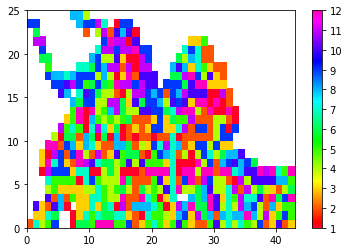

In [22]:

cmap = plt.cm.gist_rainbow
plt.pcolormesh(min_mean_mon,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(1,13))
cbar.set_ticklabels(np.arange(1,13))


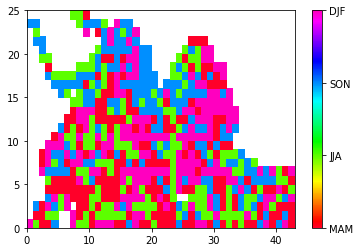

In [23]:
cmap = plt.cm.gist_rainbow
plt.pcolormesh(min_mean_seas,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(['MAM','JJA','SON','DJF'])

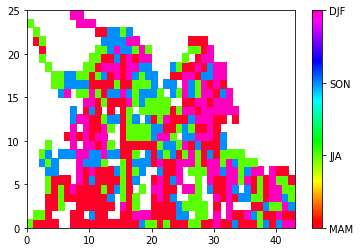

In [22]:
cmap = plt.cm.gist_rainbow
plt.pcolormesh(min_mean_seas_posIOD,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(['MAM','JJA','SON','DJF'])

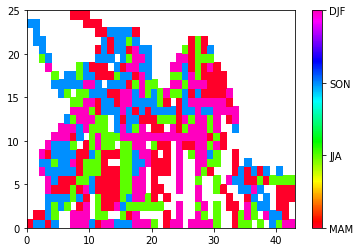

In [20]:
cmap = plt.cm.gist_rainbow
plt.pcolormesh(min_mean_seas_negIOD,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(['MAM','JJA','SON','DJF'])

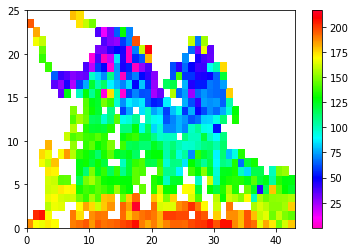

In [18]:
cmap = plt.cm.gist_rainbow_r
plt.pcolormesh(min_mean_posIOD,cmap=cmap)
cbar = plt.colorbar()

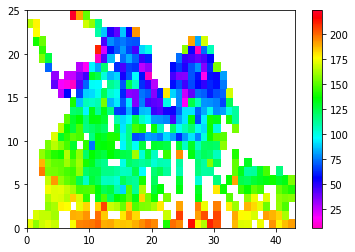

In [19]:
cmap = plt.cm.gist_rainbow_r
plt.pcolormesh(min_mean_negIOD,cmap=cmap)
cbar = plt.colorbar()

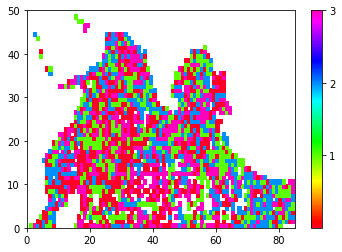

In [14]:

cmap = plt.cm.gist_rainbow
plt.pcolormesh(max_mean_seas,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(1,13))
cbar.set_ticklabels(np.arange(1,13))



In [ ]:
# you left off here on 12.08

# - find out why the season plot above isn't going very fast
# - make a plot with total, posiod, negiod
# - make a separate plot with neuiod

In [ ]:
var1 = min_mean
var2 = min_mean_seas

coastal = True


fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,6),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60

cmin1 = 25
cmax1 = 225

cmin2 = 1
cmax2 = 4

cmap1 = plt.cm.rainbow

# colors = ['royalblue', 'cyan','yellow', 'orange']
colors = ['darkorange','dodgerblue','purple', 'teal']

xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

plt.rcParams.update({'legend.fontsize': 16,
                     'legend.handlelength': 2,
                     "legend.markerscale":2,
                     'font.size': 12})

title = ['Monthly Minimum','Season of Monthly Minimum']
season_title = ['MAM','JJA','SON','DJF']
##############################################################
if coastal == True:
    ax = axes[0]
    tmp = var1.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap1,vmin=cmin1,vmax=cmax1,transform=ccrs.PlateCarree())
    ax.set_title(title[0])
    add_land(ax)
    cbar = plt.colorbar(p, ax = ax,orientation='horizontal')
    cbar.set_label('Mean 10-200dbar [$O_2$] ($\mu mol/ kg$)')

    ax = axes[1]
    add_land(ax)
    tmp = var2.flatten()
    tmp = tmp[mask]
    xx = xx[mask]
    yy = yy[mask]
    season = np.arange(1,5)
    for ss in range(4):
        ind = tmp == (season[ss])
        
        p = ax.scatter(xx[ind],yy[ind],c = colors[ss],label = season_title[ss],marker='s',s= sz,
                          cmap=cmap2,vmin=cmin2,vmax=cmax2,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(title[1])
    # get first axes height
    
    box0 = axes[0].get_position()
    box = ax.get_position()
    ax.set_position([box.x0, box0.y0, box0.width, box0.height])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.36),
          ncol=4, fancybox=True, shadow=True)

else:
    ax = axes[0]
    tmp = var1.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap1,vmin=cmin1,vmax=cmax1,transform=ccrs.PlateCarree())
    ax.set_title(title[0])
    add_land(ax)
    cbar = plt.colorbar(p, ax = ax,orientation='horizontal')
    cbar.set_label('Mean 10-200dbar [$O_2$] ($\mu mol/ kg$)')

    ax = axes[1]
    add_land(ax)
    tmp = var2.flatten()
    season = np.arange(1,5)
    for ss in range(4):
        ind = tmp == (season[ss])
        p = ax.scatter(xx[ind],yy[ind],c = colors[ss],label = season_title[ss],marker='s',s= sz,
                          cmap=cmap2,vmin=cmin2,vmax=cmax2,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(title[1])
    # get first axes height
    
    box0 = axes[0].get_position()
    box = ax.get_position()
    ax.set_position([box.x0, box0.y0, box0.width, box0.height])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.36),
          ncol=4, fancybox=True, shadow=True)
